# Generative Adversarial Network

## For Google Colab

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !unzip ./sample_data/img_align_celeba.zip

## Imports

In [3]:
from torch import nn
from torch import full
from torch import randn
from torch import manual_seed
from torch import save
from torch import float as tfloat
from torch import device as tdevice
from torch.utils.data import DataLoader
from torch.optim import Adam
from IPython.display import HTML

import os
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.animation as animation

In [4]:
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
manual_seed(manualSeed)

Random Seed:  999


In [5]:
ngpu = 1
device = tdevice("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

## Data

In [6]:
image_size = 64
batch_size = 128

In [7]:
dataset = dset.ImageFolder(
    root='./data/celeba/',
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]))

In [8]:
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

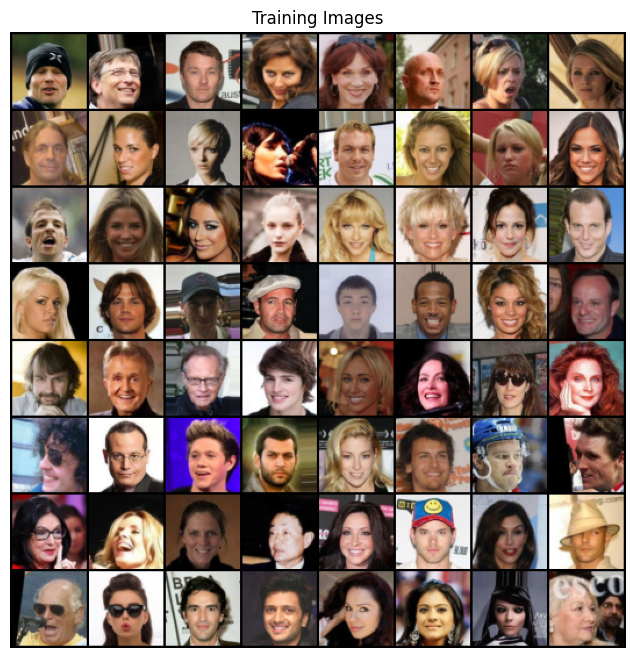

In [9]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## Generative Adversarial Network (GAN)

### Generator

In [10]:
class Generator(nn.Module):
    """
    Generator.
    """
    def __init__(self, z_dim, n_feature_maps, n_channels):
        super(Generator, self).__init__()

        self.z_dim = z_dim
        self.n_feature_maps = n_feature_maps
        self.n_channels = n_channels

        self._init_network()

    def _init_network(self):
        layer = []

        # input is Z, going into a convolution
        layer.append(nn.ConvTranspose2d(
            self.z_dim,
            self.n_feature_maps * 8,
            4,
            1,
            0,
            bias=False
        ))

        layer.append(nn.BatchNorm2d(self.n_feature_maps * 8))
        layer.append(nn.ReLU(True))

        # state size. ``(ngf*8) x 4 x 4``
        layer.append(nn.ConvTranspose2d(
            self.n_feature_maps * 8,
            self.n_feature_maps * 4,
            4,
            2,
            1,
            bias=False
        ))

        layer.append(nn.BatchNorm2d(self.n_feature_maps * 4))
        layer.append(nn.ReLU(True))

        # state size. ``(ngf*4) x 8 x 8``
        layer.append(nn.ConvTranspose2d(
            self.n_feature_maps * 4,
            self.n_feature_maps * 2,
            4,
            2,
            1,
            bias=False
        ))

        layer.append(nn.BatchNorm2d(self.n_feature_maps * 2))
        layer.append(nn.ReLU(True))

        # state size. ``(ngf*2) x 16 x 16``
        layer.append(nn.ConvTranspose2d(
            self.n_feature_maps * 2,
            self.n_feature_maps,
            4,
            2,
            1,
            bias=False
        ))

        layer.append(nn.BatchNorm2d(self.n_feature_maps))
        layer.append(nn.ReLU(True))

        # state size. ``(ngf) x 32 x 32``
        layer.append(nn.ConvTranspose2d(
            self.n_feature_maps,
            self.n_channels,
            4,
            2,
            1,
            bias=False
        ))

        layer.append(nn.Tanh())

        self.main = nn.Sequential(*layer)

    def forward(self, x):
        """
        Forward operation for the generator network.
        """
        return self.main(x)

### Discriminator

In [11]:
class Discriminator(nn.Module):
    """
    Discriminator.
    """
    def __init__(self, n_channels, n_feature_maps):
        super(Discriminator, self).__init__()

        self.n_channels = n_channels
        self.n_feature_maps = n_feature_maps

        self._init_network()

    def _init_network(self):
        layers = []

        # input is ``(nc) x 64 x 64``
        layers.append(nn.Conv2d(
            self.n_channels,
            self.n_feature_maps,
            4,
            2,
            1,
            bias=False
        ))

        layers.append(nn.LeakyReLU(0.2, inplace=True))

        # state size. ``(ndf) x 32 x 32``
        layers.append(nn.Conv2d(
            self.n_feature_maps,
            self.n_feature_maps * 2,
            4,
            2,
            1,
            bias=False
        ))
        layers.append(nn.BatchNorm2d(self.n_feature_maps * 2))
        layers.append(nn.LeakyReLU(0.2, inplace=True))

        # state size. ``(ndf*2) x 16 x 16``
        layers.append(nn.Conv2d(
            self.n_feature_maps * 2,
            self.n_feature_maps * 4,
            4,
            2,
            1,
            bias=False
        ))
        layers.append(nn.BatchNorm2d(self.n_feature_maps * 4))
        layers.append(nn.LeakyReLU(0.2, inplace=True))

        # state size. ``(ndf*4) x 8 x 8``
        layers.append(nn.Conv2d(
            self.n_feature_maps * 4,
            self.n_feature_maps * 8,
            4,
            2,
            1,
            bias=False
        ))
        layers.append(nn.BatchNorm2d(self.n_feature_maps * 8))
        layers.append(nn.LeakyReLU(0.2, inplace=True))

        # state size. ``(ndf*8) x 4 x 4``
        layers.append(nn.Conv2d(
            self.n_feature_maps * 8,
            1,
            4,
            1,
            0,
            bias=False
        ))
        layers.append(nn.Sigmoid())

        self.main = nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward Operation.
        """
        return self.main(x)

### GAN

In [12]:
class GAN(object):
    """
    Generative Adversarial Network.
    """
    @staticmethod
    def load(path, device, ngpus=0):
        gan = GAN(device, ngpus)
        gan.discriminator.load_state_dict(torch.load(os.path.join(path, 'discriminator.obj')))
        gan.generator.load_state_dict(torch.load(os.path.join(path, 'generator.obj')))
        
    def __init__(self, device, n_gpus=0):
        self.device = device
        self.n_gpus = n_gpus
        self._init_model()

    def _init_model(self):
        self.discriminator = Discriminator(3, 64).to(self.device)
        self.discriminator.apply(self._weighs_init)

        if (self.device.type == 'cuda') and (self.n_gpus > 1):
            self.discriminator = nn.DataParallel(self.discriminator, list(range(self.n_gpus)))

        self.generator = Generator(100, 64, 3).to(self.device)
        self.generator.apply(self._weighs_init)

        if (self.device.type == 'cuda') and (self.n_gpus > 1):
            self.generator = nn.DataParallel(self.generator, list(range(self.n_gpus)))

        self.criterion= nn.BCELoss()

        self.fixed_noise = randn(64, 100, 1, 1, device=self.device)

        self.real_label = 1.
        self.fake_label = 0.

        self.optimizer_discriminator = Adam(
            self.discriminator.parameters(),
            lr=0.0002,
            betas=(0.5, 0.999)
        )

        self.optimizer_generator = Adam(
            self.generator.parameters(),
            lr=0.0002,
            betas=(0.5, 0.999)
        )

    def train(self, n_epochs, dataloader : DataLoader):
        """
        Train the model.
        """
        img_list = []
        generator_losses = []
        discriminator_losses = []
        iters = 0
        for epoch in range(n_epochs):
            for i, data in enumerate(dataloader, 0):
                ############################
                # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
                ###########################
                ## Train with all-real batch
                self.discriminator.zero_grad()

                # Format batch
                real_cpu = data[0].to(self.device)
                b_size = real_cpu.size(0)
                label = full(
                    (b_size,),
                    self.real_label,
                    dtype=tfloat,
                    device=self.device
                )
                # Forward pass real batch through D
                output = self.discriminator(real_cpu).view(-1)
                # Calculate loss on all-real batch
                discriminator_error_real = self.criterion(output, label)
                # Calculate gradients for D in backward pass
                discriminator_error_real.backward()
                discriminator_x = output.mean().item()

                 ## Train with all-fake batch
                # Generate batch of latent vectors
                noise = randn(b_size, 100, 1, 1, device=self.device)
                # Generate fake image batch with G
                fake = self.generator(noise)
                label.fill_(self.fake_label)
                # Classify all fake batch with D
                output = self.discriminator(fake.detach()).view(-1)
                # Calculate D's loss on the all-fake batch
                error_discriminator_fake = self.criterion(output, label)
                # Calculate the gradients for this batch,
                # accumulated (summed) with previous gradients
                error_discriminator_fake.backward()
                discriminator_gradients_z1 = output.mean().item()
                # Compute error of D as sum over the fake and the real batches
                discriminator_error = discriminator_error_real + error_discriminator_fake
                # Update D
                self.optimizer_discriminator.step()

                ############################
                # (2) Update G network: maximize log(D(G(z)))
                ###########################
                self.generator.zero_grad()
                label.fill_(self.real_label)  # fake labels are real for generator cost
                # Since we just updated D, perform another forward pass of all-fake batch through D
                output = self.discriminator(fake).view(-1)
                # Calculate G's loss based on this output
                generator_error = self.criterion(output, label)
                # Calculate gradients for G
                generator_error.backward()
                discriminator_gradients_z2 = output.mean().item()
                # Update G
                self.optimizer_generator.step()

                # Output training stats
                if i % 50 == 0:
                    print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                        % (epoch, n_epochs, i, len(dataloader),
                            discriminator_error.item(), generator_error.item(), discriminator_x, discriminator_gradients_z1, discriminator_gradients_z2))

                    self._save_model(os.path.join('model', 'gan', 'checkpoint'), n_epoch=epoch, is_checkpoint=True)

                # Save Losses for plotting later
                generator_losses.append(generator_error.item())
                discriminator_losses.append(discriminator_error.item())

                # Check how the generator is doing by saving G's output on fixed_noise
                if (iters % 500 == 0) or ((epoch == n_epochs-1) and (i == len(dataloader)-1)):
                    with torch.no_grad():
                        fake = self.generator(self.fixed_noise).detach().cpu()
                    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

                    self._save_model(os.path.join('model', 'gan'))

                iters += 1

        return {
            'images': img_list,
            'generator_losses': generator_losses,
            'discriminator_losses': discriminator_losses
        }

    def _weighs_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)
    
    def _save_model(self, path, n_epoch=0, is_checkpoint=False):
        if not os.path.exists(path):
            os.makedirs(path)
        
        torch.save(self.discriminator.state_dict(), os.path.join(path, 'discriminator.obj') if not is_checkpoint else os.path.join(path, f'discriminator_{n_epoch}.obj'))
        torch.save(self.generator.state_dict(), os.path.join(path, 'generator.obj') if not is_checkpoint else os.path.join(path, f'generator_{n_epoch}.obj'))

### Train GAN

In [13]:
gan = GAN(
    device=device,
)

In [14]:
training_results = gan.train(
    n_epochs=5,
    dataloader=dataloader
)

[0/5][0/1583]	Loss_D: 1.6823	Loss_G: 5.7699	D(x): 0.6239	D(G(z)): 0.6208 / 0.0047
[0/5][50/1583]	Loss_D: 0.2933	Loss_G: 24.4741	D(x): 0.8840	D(G(z)): 0.0000 / 0.0000
[0/5][100/1583]	Loss_D: 0.4241	Loss_G: 5.8929	D(x): 0.7667	D(G(z)): 0.0112 / 0.0052
[0/5][150/1583]	Loss_D: 0.1355	Loss_G: 3.9345	D(x): 0.9308	D(G(z)): 0.0355 / 0.0321
[0/5][200/1583]	Loss_D: 1.0252	Loss_G: 4.2627	D(x): 0.5473	D(G(z)): 0.0296 / 0.0313
[0/5][250/1583]	Loss_D: 0.4708	Loss_G: 2.9467	D(x): 0.7647	D(G(z)): 0.1024 / 0.0774
[0/5][300/1583]	Loss_D: 0.7398	Loss_G: 4.7550	D(x): 0.8015	D(G(z)): 0.3107 / 0.0186
[0/5][350/1583]	Loss_D: 0.5455	Loss_G: 3.9903	D(x): 0.8022	D(G(z)): 0.2072 / 0.0322
[0/5][400/1583]	Loss_D: 0.7428	Loss_G: 3.1348	D(x): 0.6759	D(G(z)): 0.1152 / 0.0823
[0/5][450/1583]	Loss_D: 1.2537	Loss_G: 6.8507	D(x): 0.7531	D(G(z)): 0.5387 / 0.0027
[0/5][500/1583]	Loss_D: 1.0884	Loss_G: 8.2241	D(x): 0.9814	D(G(z)): 0.5309 / 0.0018
[0/5][550/1583]	Loss_D: 0.5083	Loss_G: 4.2585	D(x): 0.7650	D(G(z)): 0.1203 / 0

KeyboardInterrupt: 

## Results

### Loss versus training iteration

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

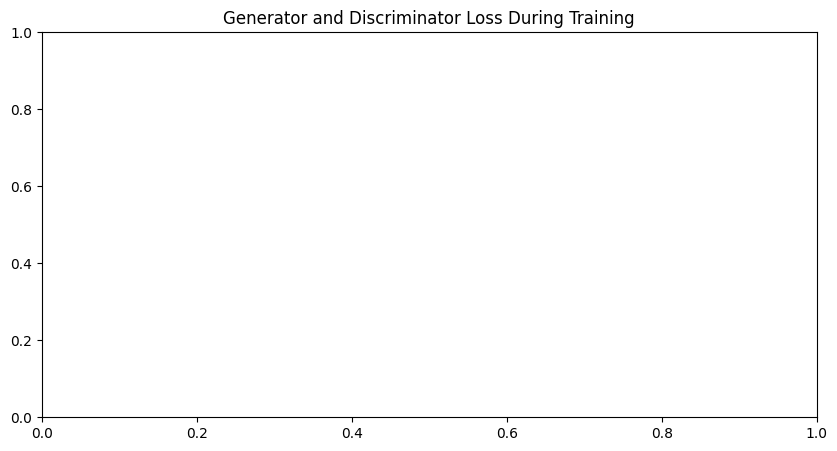

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(training_results['generator_losses'],label="G")
plt.plot(training_results['discriminator_losses'],label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Visualization of G’s progression

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in training_results['images']]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

### Generate some Images

In [16]:
saved_gan = GAN(
    device=device,
    n_gpus=ngpu
)

saved_gan.discriminator.load_state_dict(torch.load('model/gan/discriminator.obj'))
saved_gan.generator.load_state_dict(torch.load('model/gan/generator.obj'))

<All keys matched successfully>

In [17]:
fixed_noise = randn(64, 100, 1, 1, device=device)

In [18]:
with torch.no_grad():
    fake = saved_gan.generator(fixed_noise).detach().cpu()

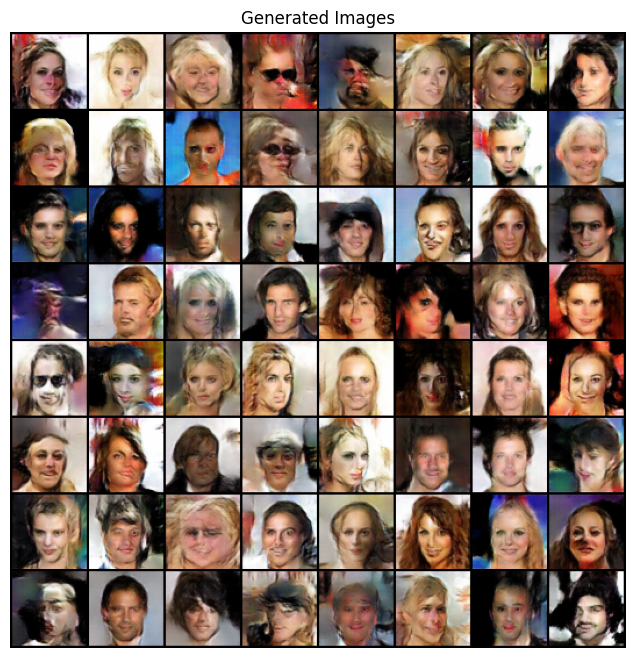

In [26]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(fake.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))